In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from __future__ import division

In [2]:
%matplotlib inline

In [3]:
def retrieve_match_IDs_by_hero(playerID,key,heroID,startAtMatch='0'):
    '''
    Retrieves match history information for a player in json format and then returns
    a list of matchIDs the player was involved in to be used to retrieve match details
    
    Regardless of parameters enetered, WebAPI will only return the 500 most recent matches
    (100 at a time maximum); to get around this, implement a for loop to search matches
    by hero played assuming no hero has been played more than 500 times.
    
    Parameters
    -----------
    playerID (str): Numerical Steam playerID
    key (str): Personal Steam WebAPI key
    startAtMatch (str): Tells API what match to start at and returns descending matches
                        Disables when 0. When non-zero, take the latest matchID found and subtract
                        one to be used in function recursion.
    heroID (str): Hero numerical identifier to serach matches where playerID played heroID.
                  Default of 0 searches by any hero.
    '''
    
    r = requests.get('https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?matches_requested=100&account_id=%s&key=%s&start_at_match_id=%s&hero_id=%s' % (playerID, key, startAtMatch, heroID))
    resultJ = json.loads(r.text)
    matchIDList = []
    for match in resultJ['result']['matches']:
        matchIDList.append(match['match_id'])
    
    if len(resultJ['result']['matches']) == 100:    #if pulled full 100 matches, request next set of 100 until all matches retrieved
        newStart = matchIDList[-1]-1
        matchIDList = matchIDList + retrieve_match_IDs_by_hero(playerID,key,heroID,newStart)
        time.sleep(1)        #to avoid rejection from calling API too often
    
    return matchIDList

In [4]:
def retrieve_all_match_IDs(playerID,key):
    '''
    Uses retrieve_match_IDs_by_hero and parses through every hero currently in the game
    110 heroes currently with IDs ranging from 1 to 112 as of October 2015
    '''
    
    matchIDList = []
    heroRange = list(range(1,113))   #heroIDs range from 1 to 112 currently
    heroRange.remove(24)             #no hero with ID 24... strangely
    heroRange.remove(108)            #no hero with ID 108 yet, probably Pitlord or Arc Warden
    
    for hero in heroRange:
        matchIDList = matchIDList + retrieve_match_IDs_by_hero(playerID,key,str(hero),'0')
        
    return matchIDList

In [5]:
def create_dota_dataframe(matchDetailsList):
    
    '''
    Takes in list of match detail json strings and converts
    into a pandas dataframe for easier statistical manipulation
    '''

    playerID = []                 #initialize lists for stats of interest
    playerSlot = []
    playerKills = []
    playerDeaths = []
    playerAssists = []
    playerGPM = []
    playerXPM = []
    playerHeroDamage = []
    playerTowerDamage = []
    playerLevel = []
    playerHeroID = []
    gameWonStatus = []
    matchID = []
    matchLength = []
    matchCounter = []
    gameStartTime = []

    for match in matchDetailsList:    #construct lists
        for player in match['result']['players']:
            playerID.append(player['account_id'])
            playerSlot.append(player['player_slot'])
            playerKills.append(player['kills'])
            playerDeaths.append(player['deaths'])
            playerAssists.append(player['assists'])
            playerGPM.append(player['gold_per_min'])
            playerXPM.append(player['xp_per_min'])
            playerHeroDamage.append(player['hero_damage'])
            playerTowerDamage.append(player['tower_damage'])
            playerLevel.append(player['level'])
            playerHeroID.append(player['hero_id'])
            if ((player['player_slot'] == 0) or (player['player_slot'] == 1) or (player['player_slot'] == 2) or (player['player_slot'] == 3) or (player['player_slot'] == 4)) and match['result']['radiant_win'] == True:
                gameWonStatus.append(1)
            elif ((player['player_slot'] == 128) or (player['player_slot'] == 129) or (player['player_slot'] == 130) or (player['player_slot'] == 131) or (player['player_slot'] == 132)) and match['result']['radiant_win'] == False:
                gameWonStatus.append(1)
            else:
                gameWonStatus.append(0)
            matchID.append(match['result']['match_id'])
            matchLength.append(match['result']['duration'])
            matchCounter.append(1)
            gameStartTime.append(match['result']['start_time'])

    #construct dictionary to build data frame
    referenceDict = {'Player ID': playerID, 'Player Slot': playerSlot, 'Kills': playerKills, 'Deaths': playerDeaths, 'Assists': playerAssists, 'GPM': playerGPM, 'XPM': playerXPM, 'Hero Damage': playerHeroDamage, 'Tower Damage': playerTowerDamage, 'Level': playerLevel, 'Hero ID': playerHeroID, 'Win Y/N': gameWonStatus, 'Match ID': matchID, 'Match Length (s)': matchLength, 'Match Counter': matchCounter, 'Game Start Time': gameStartTime}
    dataFrameSummary = pd.DataFrame(data=referenceDict)

    return dataFrameSummary

In [25]:
def get_stats(interestedPlayer, dataSummary):
    '''
    Reads in a dataframe and pumps out interesting/funny statistics about a player
    
    Parameters
    ----------
    interestedPlayer (str): numerical player ID as stored by steam API information
    dataSummary (dataframe): dataframe of data compiled from match history information
    
    Returns nothing, but prints out:
        Average deaths per minute in losses
        Average deaths per minute in wins
        Win-loss record when playing with me
        Average game length of wins (with me)
        Average game length of losses (with me)
        Average KDA over all games as Blue player (player slot 0)
        Total number of deaths over all games as Pink player (player slot 128)
    
    '''
    
    tempDF = dataSummary.groupby(['Player ID', 'Win Y/N']).aggregate(sum)
    averageDPMinWin = float(tempDF.loc[interestedPlayer, 1]['Deaths'])/tempDF.loc[interestedPlayer, 1]['Match Length (s)'] * 60.0
    averageDPMinLoss = float(tempDF.loc[interestedPlayer, 0]['Deaths'])/tempDF.loc[interestedPlayer, 0]['Match Length (s)'] * 60.0
    averageWinLength = tempDF.loc[interestedPlayer, 1]['Match Length (s)']/tempDF.loc[interestedPlayer, 1]['Match Counter']
    averageLossLength = tempDF.loc[interestedPlayer, 0]['Match Length (s)']/tempDF.loc[interestedPlayer, 0]['Match Counter']
    
    tempDF2 = dataSummary.groupby(['Player ID', 'Player Slot']).aggregate(sum)
    blueKDA = (tempDF2.loc[interestedPlayer, 0]['Kills']+tempDF2.loc[interestedPlayer, 0]['Assists'])/tempDF2.loc[interestedPlayer, 0]['Deaths']
    pinkTotalDeaths = tempDF2.loc[interestedPlayer, 0]['Deaths']
    
    print('Player\'s ID: %s' % interestedPlayer)
    print('Player\'s win-loss when playing with you: ' + str(tempDF.loc[interestedPlayer,1]['Match Counter']) + '-' + str(tempDF.loc[interestedPlayer,0]['Match Counter']) + ' (' + str(tempDF.loc[interestedPlayer,1]['Match Counter']/(tempDF.loc[interestedPlayer,1]['Match Counter']+tempDF.loc[interestedPlayer,0]['Match Counter'])) + ')')
    print('Player\'s average deaths per minute in wins is %s over %s matches' % (averageDPMinWin, tempDF.loc[interestedPlayer, 1]['Match Counter']))
    print('Player\'s average deaths per minute in losses is %s over %s matches' % (averageDPMinLoss, tempDF.loc[interestedPlayer, 0]['Match Counter']))
    print('Player\'s average game length when winning with you: %s seconds' %averageWinLength)
    print('Player\'s average game length when losing with you: %s seconds' %averageLossLength)
    print('Player\'s average KDA as Blue: %s' % blueKDA)
    print('Player\'s total deaths as Pink: %s' % pinkTotalDeaths)
    
    return None

In [6]:
def bin_win_rate(dataframe, numberbins):
    dfMin = dataframe['Match Length (s)'].min()
    dfMax = dataframe['Match Length (s)'].max()
    binlength = (dfMax-dfMin)/numberbins
    matchLength = []
    winRate = []
    
    for x in range (0, numberbins):
        matchLength.append(dfMin+binlength*(2*x+1)/2)
        tempDF = dataframe[dataframe['Match Length (s)']>(dfMin+x*binlength)]
        tempDF = tempDF [tempDF['Match Length (s)']<=(dfMin+(x+1)*binlength)]
        if tempDF['Match Counter'].sum() != 0:  
            winRate.append(tempDF['Win Y/N'].sum()/tempDF['Match Counter'].sum())
        else:
            winRate.append(0)
        
    return matchLength, winRate

In [55]:
key = 'D3A5ED4CAF40FD79F082BBCC58467C4C'
matchDetails = []
matchIDsList = retrieve_match_IDs_by_hero(0,key,0,0)

In [58]:
matchIDsList=matchIDsList[:2]

In [59]:
for match in matchIDsList:
    rTemp = requests.get('https://api.steampowered.com/IDOTA2Match_570/GetMatchDetails/V001/?match_id=%s&key=%s' % (match, key))
    matchDetails.append(json.loads(rTemp.text))
    time.sleep(1)

In [15]:
with open('matchdetails.txt', 'r') as text:
    matchDetailsJSON = json.load(text)

In [19]:
dotaFrame.head(25)

,Assists,Deaths,GPM,Game Start Time,Hero Damage,Hero ID,Kills,Level,Match Counter,Match ID,Match Length (s),Player ID,Player Slot,Tower Damage,Win Y/N,XPM
0,12,4,647,1446086490,16174,106,14,15,1,1899269380,1501,4294967295,0,1962,1,530
1,13,5,350,1446086490,5367,100,3,11,1,1899269380,1501,102827045,1,517,1,297
2,15,5,342,1446086490,4030,91,1,12,1,1899269380,1501,4294967295,2,737,1,333
3,12,3,642,1446086490,17456,63,14,15,1,1899269380,1501,86811043,3,5782,1,500
4,14,4,432,1446086490,7441,29,3,12,1,1899269380,1501,44039249,4,1155,1,354
5,8,3,382,1446086490,4408,1,1,14,1,1899269380,1501,46667982,128,71,0,451
6,6,8,204,1446086490,7542,2,4,10,1,1899269380,1501,47067153,129,0,0,235
7,6,6,364,1446086490,8517,6,7,12,1,1899269380,1501,86740711,130,0,0,338
8,7,12,260,1446086490,5732,97,4,11,1,1899269380,1501,30999748,131,0,0,268
9,10,6,239,1446086490,6242,71,4,10,1,1899269380,1501,6289444,132,0,0,224


In [20]:
df2 = dotaFrame.groupby('Player ID').sum()

In [22]:
df2.sort(columns='Match Counter', ascending=False, inplace=True)

In [26]:
get_stats(86740711,dotaFrame)

Player's ID: 86740711
Player's win-loss when playing with you: 1160-528 (0.687203791469)
Player's average deaths per minute in wins is 0.0853998566934 over 1160 matches
Player's average deaths per minute in losses is 0.145384109671 over 528 matches
Player's average game length when winning with you: 2213.72413793 seconds
Player's average game length when losing with you: 2575.46590909 seconds
Player's average KDA as Blue: 4.31578947368
Player's total deaths as Pink: 152


In [32]:
chocoDF = dotaFrame[dotaFrame['Player ID']==46667982]

In [28]:
chocoDF.head(25)

,Assists,Deaths,GPM,Game Start Time,Hero Damage,Hero ID,Kills,Level,Match Counter,Match ID,Match Length (s),Player ID,Player Slot,Tower Damage,Win Y/N,XPM
5,8,3,382,1446086490,4408,1,1,14,1,1899269380,1501,46667982,128,71,0,451
10,5,5,667,1443407702,20075,1,14,25,1,1825747345,3520,46667982,0,1503,0,552
20,0,6,376,1443231766,2603,1,2,14,1,1819945960,1786,46667982,0,436,0,355
35,8,0,781,1442550912,8623,1,6,20,1,1801005732,1792,46667982,128,6671,1,744
45,5,5,750,1442456943,10029,1,10,25,1,1798741618,3138,46667982,128,8688,1,619
50,7,1,779,1441850879,15670,1,8,22,1,1782134495,2062,46667982,0,5741,1,779
65,10,4,815,1441676372,21512,1,19,25,1,1777863899,2999,46667982,128,5607,1,654
79,5,1,798,1439783018,12797,1,10,22,1,1720458304,1978,46667982,132,8956,1,816
85,15,8,597,1437453200,17505,1,17,25,1,1648686480,3525,46667982,128,5611,1,558
95,10,5,475,1434171459,11827,1,12,21,1,1548472489,2645,46667982,128,547,0,551


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002FC6E978>]], dtype=object)

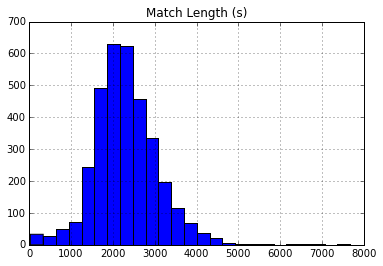

In [29]:
chocoDF.hist(column='Match Length (s)', bins=25)

In [33]:
chocoDF = chocoDF[chocoDF['Match Length (s)']<5000]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010F6C240>]], dtype=object)

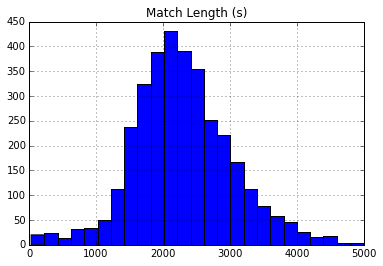

In [34]:
chocoDF.hist(column='Match Length (s)', bins=25)

In [37]:
chocoDF['Won Last Game Y/N']=chocoDF['Win Y/N'].shift(-1)

In [36]:
chocoDF.head(25)

,Assists,Deaths,GPM,Game Start Time,Hero Damage,Hero ID,Kills,Level,Match Counter,Match ID,Match Length (s),Player ID,Player Slot,Tower Damage,Win Y/N,XPM,Won Last Game Y/N
5,8,3,382,1446086490,4408,1,1,14,1,1899269380,1501,46667982,128,71,0,451,NaN
10,5,5,667,1443407702,20075,1,14,25,1,1825747345,3520,46667982,0,1503,0,552,0
20,0,6,376,1443231766,2603,1,2,14,1,1819945960,1786,46667982,0,436,0,355,0
35,8,0,781,1442550912,8623,1,6,20,1,1801005732,1792,46667982,128,6671,1,744,0
45,5,5,750,1442456943,10029,1,10,25,1,1798741618,3138,46667982,128,8688,1,619,1
50,7,1,779,1441850879,15670,1,8,22,1,1782134495,2062,46667982,0,5741,1,779,1
65,10,4,815,1441676372,21512,1,19,25,1,1777863899,2999,46667982,128,5607,1,654,1
79,5,1,798,1439783018,12797,1,10,22,1,1720458304,1978,46667982,132,8956,1,816,1
85,15,8,597,1437453200,17505,1,17,25,1,1648686480,3525,46667982,128,5611,1,558,1
95,10,5,475,1434171459,11827,1,12,21,1,1548472489,2645,46667982,128,547,0,551,1


In [38]:
wonLastDF = chocoDF[chocoDF['Won Last Game Y/N']==1]

In [39]:
lostLastDF = chocoDF[chocoDF['Won Last Game Y/N']==0]

In [40]:
wonLastDF['Win Y/N'].sum()/wonLastDF['Match Counter'].sum()

0.64658823529411769

In [42]:
lostLastDF['Win Y/N'].sum()/lostLastDF['Match Counter'].sum()

0.58534684333593145

In [44]:
wr_x, wr_y = bin_win_rate(chocoDF, 25)

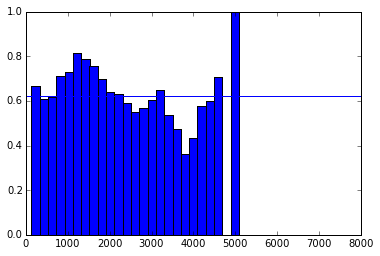

In [45]:
plt.bar(wr_x,wr_y,width=200)
plt.plot([0,8000],[0.623,0.623])

In [46]:
chen = dotaFrame[dotaFrame['Hero ID']==66]

In [47]:
wr_x, wr_y = bin_win_rate(chen,20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000035326550>]], dtype=object)

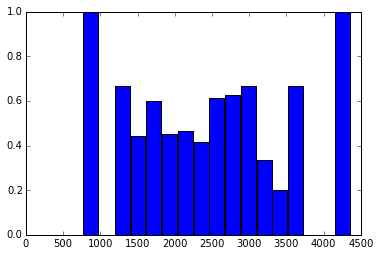

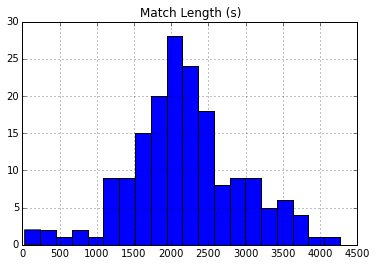

In [54]:
plt.bar(wr_x,wr_y,width=200)
chen.hist(column='Match Length (s)', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000348093C8>]], dtype=object)

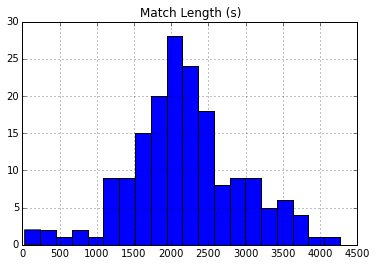